In this notebook, we will generate mock data for the DESY3, KiDS-1000 and HSCDR1 weak lensing samples.

The input power spectra comes from Baccoemu and the baryon suppression is taken directly from BAHAMAS. The cosmological paramters are the BF with DES+KiDS+HSC with baryons.

In [1]:
import numpy as np
import pyccl as ccl
import sacc
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import scipy

In [2]:
# s = sacc.Sacc.load_fits('/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG.fits') # Load the SACC file
s = sacc.Sacc.load_fits('./cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG_mockEuclidEmulator2_BAHAMAS_BF_noiseless.fits') # Load the SACC file
s.keep_selection(data_type='cl_ee')

In [3]:
# Define functions to read sims Pks
def get_a_k_Sk_from_table(pktable_b, pktable_dmo):
    z = np.unique(pktable_b[0])[::-1]
    k = np.unique(pktable_b[1]) * h

    assert np.all(pktable_dmo[0] == pktable_b[0])
    assert np.all(pktable_dmo[1] == pktable_b[1])

    k_arr = []
    Sk_arr = []
    for i, zi in enumerate(z):
        sel_b = pktable_b[0] == zi

        ki = pktable_b[1, sel_b] * h
        Sk = pktable_b[2, sel_b] / pktable_dmo[2, sel_b]
        
        assert np.all(ki == k)
        Sk_arr.append(Sk)
        
    Sk_arr = np.array(Sk_arr)

    return 1/(1+z), k, Sk_arr

def get_a_k_Pk_from_table(pktable_b):
    z = np.unique(pktable_b[0])[::-1]
    k = np.unique(pktable_b[1]) * h
    
    k_arr = []
    Pk_arr = []
    for i, zi in enumerate(z):
        sel_b = pktable_b[0] == zi

        ki = pktable_b[1, sel_b] * h
        Pk = pktable_b[2, sel_b] / h**3
        
        assert np.all(ki == k)
        Pk_arr.append(Pk)
        
    Pk_arr = np.array(Pk_arr)

    return 1/(1+z), k, Pk_arr

# Initiate CCL Cosmology (Planck2015 with mnu=0.06eV)

# Load DMO power spectrum (BACCOEmu)
pkfile = np.load('./BACCOEmu_kmax10_baryonbf.npz', allow_pickle=True)
pkdmo = ccl.Pk2D(a_arr=pkfile['expfactors'], lk_arr=np.log(pkfile['k [1/Mpc]']), pk_arr=np.log(pkfile['Pk GrO [Mpc]^3']), is_logp=True)

cosmopars = dict(pkfile['cosmopars'].tolist())
cosmopars.update({'sigma8_tot': float(pkfile['sigma8 tot'])})
cosmopars['omega_matter'] = cosmopars['omega_cold'] + cosmopars['neutrino_mass'] / 93.14 / cosmopars['hubble']**2
h = cosmopars['hubble']

# Initiate CCL Cosmology
cosmo = ccl.Cosmology(Omega_c=cosmopars['omega_cold'] - cosmopars['omega_baryon'], Omega_b=cosmopars['omega_baryon'],
                      h=cosmopars['hubble'], sigma8=cosmopars['sigma8_tot'], n_s=cosmopars['ns'], m_nu=cosmopars['neutrino_mass'])
ccl.sigma8(cosmo)

# Load the baryon boost (BAHAMAS)
pktable_dmo = np.loadtxt("../baryonic_suppressions_pk/powtable_DMONLY_2fluid_nu0.06_Planck2015_L400N1024.dat", unpack=True, usecols=(0, 1, 2))
pktable_b = np.loadtxt("../baryonic_suppressions_pk/powtable_BAHAMAS_nu0.06_Planck2015.dat", unpack=True, usecols=(0, 1, 2))
# Get baryon boost
a, k, Sk = get_a_k_Sk_from_table(pktable_b, pktable_dmo)
sk = ccl.Pk2D(a_arr=a, lk_arr=np.log(k), pk_arr=np.log(Sk), is_logp=True)
# Get tabulated Pkb
a, k, Pkb = get_a_k_Pk_from_table(pktable_b)
pkb = ccl.Pk2D(a_arr=a, lk_arr=np.log(k), pk_arr=np.log(Pkb), is_logp=True)

# Combine them
a_arr = np.sort(np.unique(np.concatenate([a, pkfile['expfactors']])))
k_arr = np.sort(np.unique(np.concatenate([k, pkfile['k [1/Mpc]']])))
pk = []
for i, ai in enumerate(a_arr):
    pk.append(pkdmo(k_arr, ai, cosmo) * sk(k_arr, ai, cosmo))
pk = ccl.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=np.log(pk), is_logp=True)

/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons/lib/python3.9/site-packages/pyccl/core.py:745: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


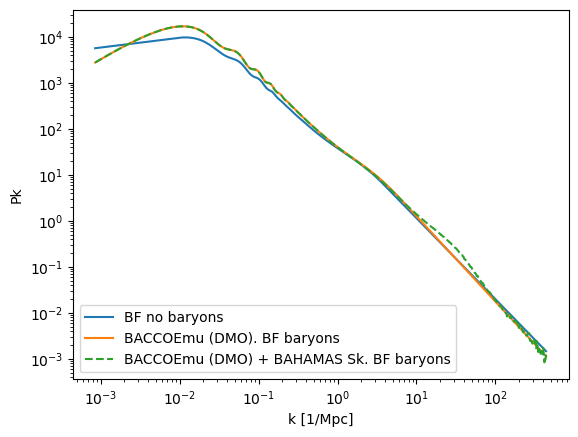

In [4]:
pkfile = np.load('./BlindCarlosPk2.npz', allow_pickle=True)
pkbf_nob = ccl.Pk2D(a_arr=pkfile['expfactors'], lk_arr=np.log(pkfile['k [1/Mpc]']), pk_arr=np.log(pkfile['Pk GrO [Mpc]^3']), is_logp=True)

plt.loglog(k_arr, pkbf_nob(k_arr, 0.25, cosmo), label='BF no baryons')
plt.loglog(k_arr, pkdmo(k_arr, 0.25, cosmo), label='BACCOEmu (DMO). BF baryons')
plt.loglog(k_arr, pk(k_arr, 0.25, cosmo), ls='--', label='BACCOEmu (DMO) + BAHAMAS Sk. BF baryons')

plt.legend()
plt.xlabel('k [1/Mpc]')
plt.ylabel('Pk')
plt.show()
plt.close()

In [5]:
# Generate the angular power spectra

# Redshift shifts
dz_shifts = {'DESY3wl__0': 0,
             'DESY3wl__1': 0,
             'DESY3wl__2': 0, 
             'DESY3wl__3': 0,
             'KiDS1000__0': 0,
             'KiDS1000__1': -0.002,
             'KiDS1000__2': -0.013,
             'KiDS1000__3': -0.011,
             'KiDS1000__4': 0.006,
             'HSCDR1wl__0': 0,
             'HSCDR1wl__1': 0,
             'HSCDR1wl__2': 0,
             'HSCDR1wl__3': 0}

# Multiplicative bias
m_wl = {'DESY3wl__0': -0.0063,
         'DESY3wl__1': -0.0198,
         'DESY3wl__2': -0.0241, 
         'DESY3wl__3': -0.0369,
         'KiDS1000__0': 0,
         'KiDS1000__1': 0.,
         'KiDS1000__2': 0.,
         'KiDS1000__3': 0.,
         'KiDS1000__4': 0.,
         'HSCDR1wl__0': 0,
         'HSCDR1wl__1': 0,
         'HSCDR1wl__2': 0,
         'HSCDR1wl__3': 0}

# Noise
# nl = {f'DESY3wl__{i}': np.load(f'/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/DESY3wl__2x2pt_4096/DESY3wl_DESY3wl/cl_DESY3wl__{i}_DESY3wl__{i}.npz')['nl'][0] for i in range(4)}
# nl.update({f'KiDS1000__{i}': np.load(f'/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/KiDS1000__2x2pt_4096/KiDS1000_KiDS1000/cl_KiDS1000__{i}_KiDS1000__{i}.npz')['nl'][0] for i in range(5)})
# nl.update( {f'HSCDR1wl__{i}': np.load(f'/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/HSCDR1wl__2x2pt_4096/HSCDR1wl_HSCDR1wl/cl_HSCDR1wl__{i}_HSCDR1wl__{i}.npz')['nl'][0] for i in range(4)})

# Instatiate the ccl tracers
ccl_tracers = {}
z = np.linspace(0, 4, 100)

for trn, trv in s.tracers.items():
    dndz = interp1d(trv.z, trv.nz, bounds_error=False, fill_value=0) # Interpolate the dndz
    ccl_tracers[trn] = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz(z - dz_shifts[trn])), has_shear=True, ia_bias=None)
    
# Compute the angular power spectrum
clmock = {}
clmock_mean = np.zeros_like(s.mean)
for trs in s.get_tracer_combinations():
    ix = s.indices(tracers=trs)
    bpw = s.get_bandpower_windows(ix)
    l_bpw = bpw.values
    w_bpw = bpw.weight.T
    
    cl = ccl.angular_cl(cosmo, ccl_tracers[trs[0]], ccl_tracers[trs[1]], l_bpw, p_of_k_a=pk)
    clbin = w_bpw.dot(cl)
    clfinal = (1+m_wl[trs[0]]) * (1 + m_wl[trs[1]]) * clbin
    
    clmock[trs] = clfinal
    clmock_mean[ix] = clfinal

# Create sacc file with these clmocks
smock_nn = s.copy()
smock_nn.mean = clmock_mean
smock_nn.save_fits('./cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG_mockBACCOEmu_BAHAMAStable_BFb_noiseless.fits', overwrite=True)
    
# Generate Gaussian realization
# clmock_mean = np.random.multivariate_normal(mean=clmock_mean, cov=s.covariance.covmat)

# # Create sacc file with these clmocks
# smock = s.copy()
# smock.mean = clmock_mean
# smock.save_fits('./cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG_BAHAMAStable.fits', overwrite=True)

/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons/lib/python3.9/site-packages/pyccl/tracers.py:110: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
  warnings.warn(


In [6]:
# To use the same generated last time (with no seed provided)
# smock = sacc.Sacc.load_fits('./cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG_mockEuclidEmulator2_BAHAMAS.fits')

In [10]:
d = smock_nn.mean - s.mean
icov = np.linalg.inv(s.covariance.covmat)
d.dot(icov.dot(d)), s.mean.size

(6.8067985235574495, 1145)

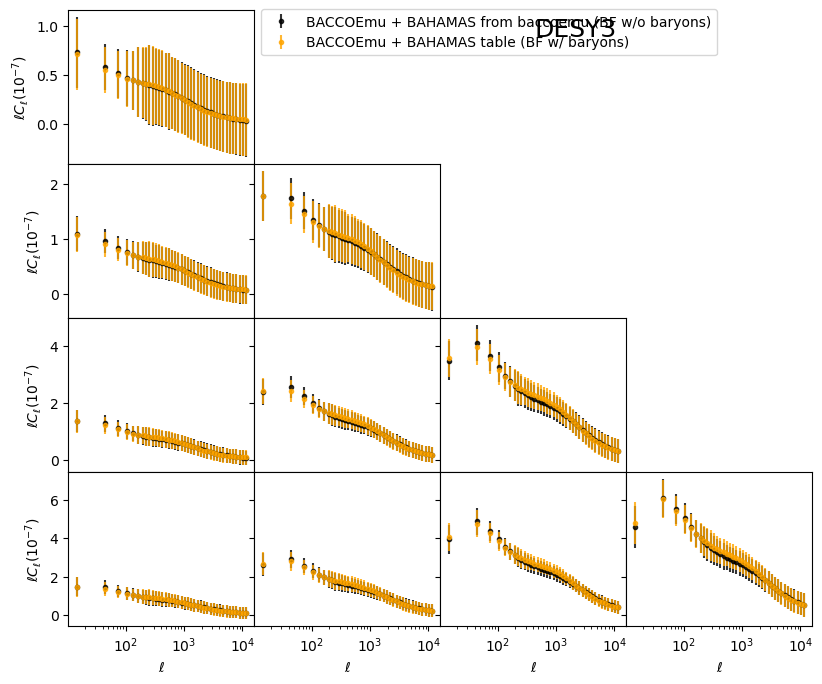

In [7]:
survey = 'DESY3'
nbin = 4


f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    ell, cl, cov, ind = s.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='k', label='BACCOEmu + BAHAMAS from baccoemu (BF w/o baryons)', alpha=0.8)    
    
    # Mock noiseless
    ell, cl, cov, ind = smock_nn.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='orange', label='BACCOEmu + BAHAMAS table (BF w/ baryons)', alpha=0.8)

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()

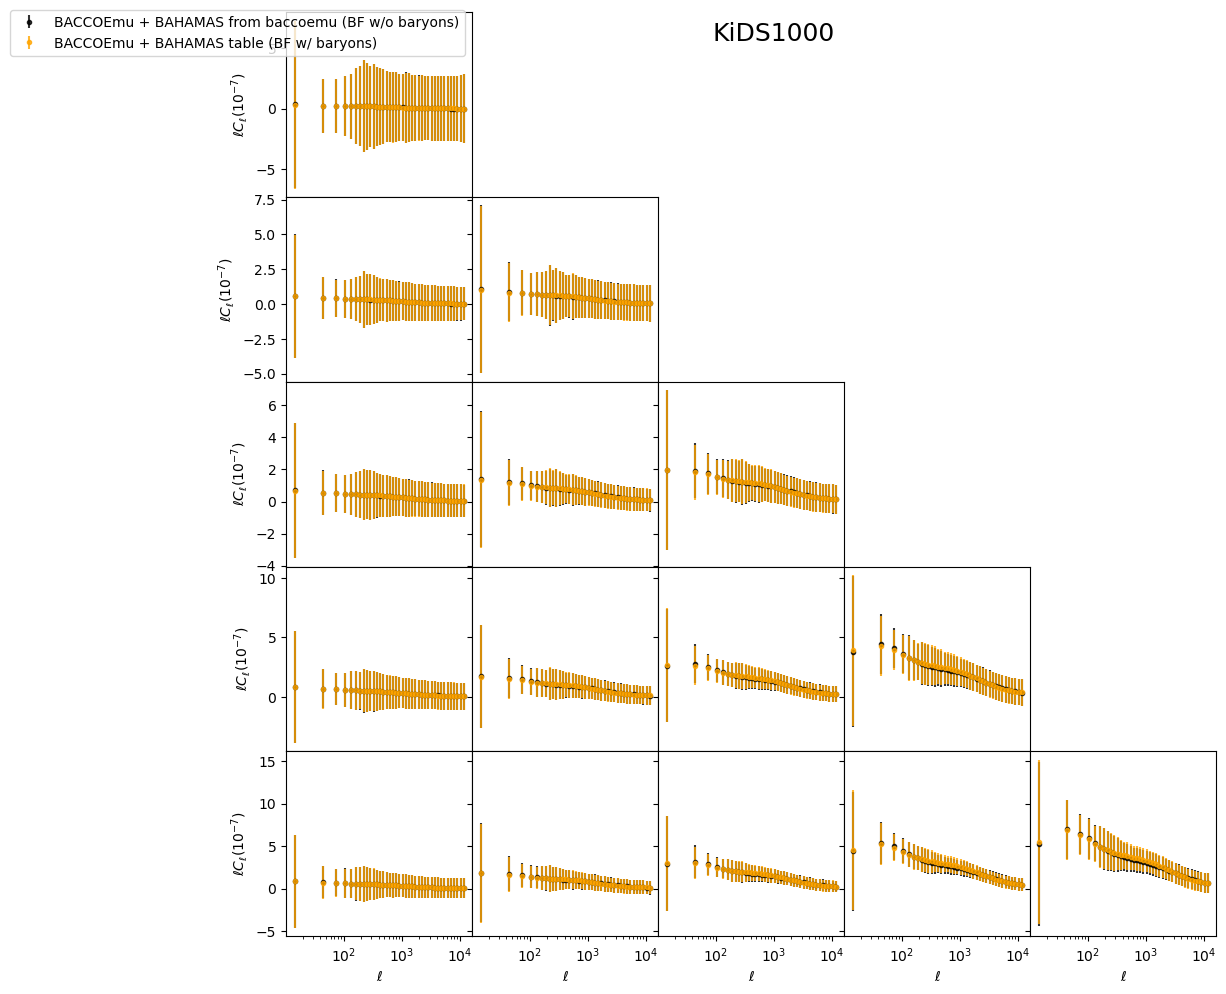

In [8]:
survey = 'KiDS1000'
nbin = 5


f, ax = plt.subplots(nbin, nbin, figsize=(12, 12), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    ell, cl, cov, ind = s.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='k', label='BACCOEmu + BAHAMAS from baccoemu (BF w/o baryons)', alpha=0.8)    
    
    # Mock noiseless
    ell, cl, cov, ind = smock_nn.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='orange', label='BACCOEmu + BAHAMAS table (BF w/ baryons)', alpha=0.8)
    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()

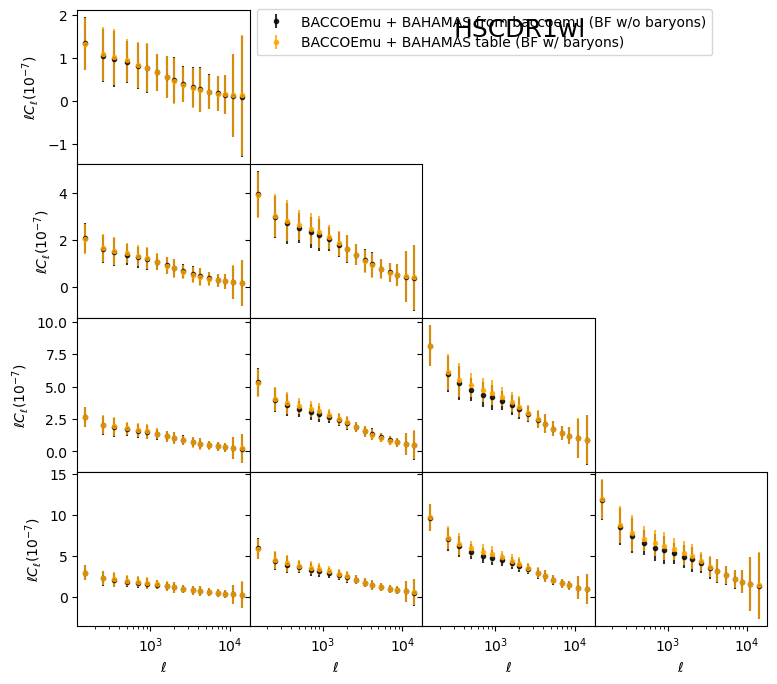

In [9]:
survey = 'HSCDR1wl'
nbin = 4


f, ax = plt.subplots(nbin, nbin, figsize=(8.9, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    ell, cl, cov, ind = s.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='k', label='BACCOEmu + BAHAMAS from baccoemu (BF w/o baryons)', alpha=0.8)    
    
    # Mock noiseless
    ell, cl, cov, ind = smock_nn.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='orange', label='BACCOEmu + BAHAMAS table (BF w/ baryons)', alpha=0.8)

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()